In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from skorch.callbacks import EpochScoring
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.signal import savgol_filter
from scipy.stats import zscore

In [3]:
data = pd.read_csv("./train.csv")

spectrum = data.iloc[:, 6:]

#spectrum_filtered = pd.DataFrame(savgol_filter(spectrum, 7, 3, deriv = 2, axis = 0))
#spectrum_filtered_st = zscore(spectrum_filtered, axis = 1)

X = spectrum
y = data["PURITY"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

standardizer = StandardScaler()
X_train_standardized = standardizer.fit_transform(X_train)
X_valid_standardized = standardizer.transform(X_valid)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_standardized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_valid_tensor = torch.tensor(X_valid_standardized, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).reshape(-1, 1)



In [4]:
#check for dimensions
print("Dimensions de X_train_tensor :", X_train_tensor.shape)
print("Dimensions de y_train_tensor :", y_train_tensor.shape)
print("Dimensions de X_valid_tensor :", X_valid_tensor.shape)
print("Dimensions de y_valid_tensor :", y_valid_tensor.shape)


Dimensions de X_train_tensor : torch.Size([1040, 125])
Dimensions de y_train_tensor : torch.Size([1040, 1])
Dimensions de X_valid_tensor : torch.Size([260, 125])
Dimensions de y_valid_tensor : torch.Size([260, 1])


In [5]:
class SimpleNN(nn.Module):
    def __init__(self, fc1_out_features=100, fc2_out_features=64):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train_tensor.shape[1], fc1_out_features)
        self.fc2 = nn.Linear(fc1_out_features, fc2_out_features)
        self.fc3 = nn.Linear(fc2_out_features, 1)

      
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

MSE : 65.8006
t_score : 0.5038461685180664


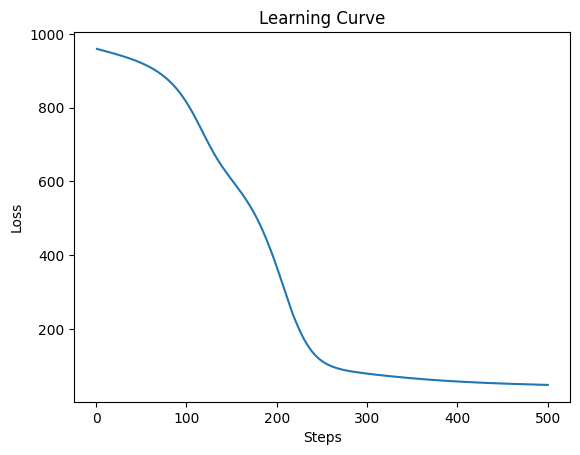

In [12]:
# Initialiser le modèle
input_size = X_train_tensor.shape[1]
model = SimpleNN(input_size)

# Définir la fonction de perte
criterion = nn.MSELoss()

# Définir la descente de gradient
def gradient_descent(model, criterion, X_train_tensor, y_train_tensor, eta=0.001, T=10000):
    optimizer = optim.SGD(model.parameters(), lr=eta)
    learning_curve = []
    steps = []
    
    for t in range(T):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        learning_curve.append(loss.item())
        steps.append(t+1)
        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters
    return (model, learning_curve, steps)

# Entraîner le modèle avec la descente de gradient
model, learning_curve, steps = gradient_descent(model, criterion, X_train_tensor, y_train_tensor, eta=0.0001, T=500)

# Générer les prédictions sur les données de validation
model.eval()
with torch.no_grad():
    y_pred = model(X_valid_tensor).detach().numpy()

# Calculer la MSE
mse = np.mean((y_pred - y_valid_tensor.numpy())**2)
print("MSE :", mse)

# Calculer le t_score
predictions_tensor = torch.tensor(y_pred, dtype=torch.float32)
t_score = torch.mean((torch.abs(predictions_tensor - y_valid_tensor) <= 5).float())
print("t_score :", t_score.item())

# Afficher la courbe d'apprentissage
import matplotlib.pyplot as plt
plt.plot(steps, learning_curve)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.show()

In [8]:
#création du modèle
net = NeuralNetRegressor(
    SimpleNN,
    max_epochs=10,
    lr=0.1,
    iterator_train__shuffle=False,
    criterion=torch.nn.MSELoss,
    optimizer=torch.optim.Adam,
    verbose=False,
    #callbacks=[EpochScoring('neg_mean_squared_error', lower_is_better=True)]
)

net.fit(X_train_tensor, y_train_tensor)
y_pred = net.predict(X_valid_tensor)
mse = mean_squared_error(y_valid_tensor.numpy(), y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 773.70575


In [9]:

params = {
    'lr': [0.01, 0.02, 0.05],
    'max_epochs': [20,25],
    'module__fc1_out_features': [100, 128],
    'module__fc2_out_features': [64, 128],
}

grid_search = GridSearchCV(net, params, refit=True, cv=5, scoring='neg_mean_squared_error',verbose=0)
grid_result = grid_search.fit(X_train_tensor, y_train_tensor)

print("Best MSE: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best MSE: -39.706443 using {'lr': 0.02, 'max_epochs': 25, 'module__fc1_out_features': 100, 'module__fc2_out_features': 128}


In [10]:

mach2 = grid_result.best_estimator_
mach2.fit(X_train_tensor, y_train_tensor)
predictions = mach2.predict(torch.tensor(X_valid_tensor[172:, :], dtype=torch.float32))
#mach2.get_params()

C:\Users\elvua\AppData\Local\Temp\ipykernel_9156\2082825715.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = mach2.predict(torch.tensor(X_valid_tensor[172:, :], dtype=torch.float32))


In [11]:

predictions_tensor = torch.tensor(predictions, dtype=torch.float32)
y_valid_tensor_sliced = y_valid_tensor[172:, :]  
t_score = torch.mean((torch.abs(predictions_tensor - y_valid_tensor_sliced) <= 5).float())
print('t_score',t_score.item())

t_score 0.5795454382896423
